# 8.2 Adagrad

In [1]:
import os.path
if  not os.path.isfile("OPT_helper.py"):
    !wget https://github.com/deeplearning-itba/optimizadores/raw/master/OPT_helper.py

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.display import YouTubeVideo
from sklearn.model_selection import train_test_split
import os.path
import keras
import numpy as np
from matplotlib import pyplot as plt
import OPT_helper
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


/Users/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  
/Users/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


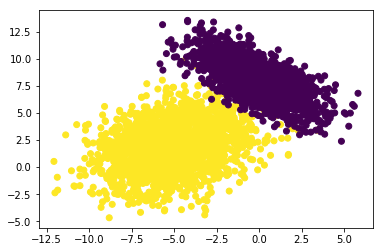

In [3]:
np.random.seed(432)
X = np.vstack([np.random.multivariate_normal([-5,2], [[2,5],[5,1]], 2000),
             np.random.multivariate_normal([0,8], [[2,-3],[-3,2]], 2000)])
y = np.hstack([np.ones(2000),
             np.zeros(2000)])

#X=df[['Peso','Altura']].values
#y=df['Genero'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [312]:
y_test

array([0, 1, 1, ..., 1, 1, 0])

# Adagrad 

- SGD tiene problemas cuando el vector de entrada, es sparso (muchos ceros).
- En estos casos puede ser que haya entradas que muchas veces son cero y los parámetros correspondientes no se actualizarán.
- La idea de Adagrad es prevenir esto, definiendo un learning rate para cada uno de los parámetros.
- Los parámetros que se actualizan mucho, se actualizarán con un learning rate mas chico.
- Los parámetros que se actualizan con poca frecuencia, se actualizarán con un learning rate mas grande.

Para lograr esto de manera automática, Adagrad propone lo siguiente:

- Se define una matriz diagonal $G(k)$ en cuyos elementos $G_{i,i}(k)$ se encuentran la acumulación de las derivadas parciales $\frac{\partial J(W(k))}{\partial w_i}$ al cuadrado para cada uno de los instantes k:  

$$ G_{i,i}(k)=\sum_{t=0}^k{\left( \frac{\partial J(W(t))}{\partial w_i} \right)^2}$$

Nótese que $\frac{\partial J(W(k))}{\partial w_i}$ es proporcional a cuánto se actualizó el peso $w_i$ en durante el instante t, por lo que la suma tiene relación con cuánto se movió el peso $w_i$ a lo largo del entrenamiento.
El learning rate que se utilizará en la iteración k-ésima:

$$lr(k)=\frac{lr_{base}}{\sqrt{G(k) + \epsilon}}$$

El $\epsilon$ está para impedir la división por cero y suele valer 1e-8.

# Red Neuronal de 1 capa

In [4]:
# Esta función recibe un modelo y devuelve los pesos que se quieren loggear
def get_weights(model):
    weights=list()
    
    for layer in model.layers[0:]:
        weights.append([layer.get_weights()[1][0],layer.get_weights()[0][0][0],layer.get_weights()[0][1][0]])
    
    return weights

def set_weights(model,w0,w1,w2):
    weights = model.layers[0].get_weights()
    weights[0][0][0] = w1
    weights[0][1][0] = w2
    weights[1][0] = w0
    model.layers[0].set_weights(weights)

def reset_weights(model):
    weights = model.layers[-1].get_weights()
    weights[0][0] = weights[0][0] * 0
    model.layers[-1].set_weights(weights)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.Adagrad(lr=0.5, 
                               epsilon=1e-8, 
                               decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=40, verbose=1, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.6, 
                           patience=20, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)
logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.767115,
                                  w2_opt=-2.05875,
                                  w0_opt=10.087935,
                                  plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping, reduceLR])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


- La contra mas fuerte que tiene Adagrad es que a medida que se acumulan los cuadrados de los gradientes, el learning rate se va haciendo cada vez mas chico monótonamente.
- Esto hace que el learning rate en un punto sea tan chico, que las variaciones en los pesos son despreciables.
- Adadelta ataca este problema.